In [55]:
import numpy as np
import cv2
from imutils import paths
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [56]:
imagePaths = list(paths.list_images('data'))
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
    # load the image, swap color channels, and resize it to be a fixed
    # 299x299 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (299, 299))
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 1]
data = np.array(data) / 255.0
labels = np.array(labels)

In [58]:
from sklearn.preprocessing import LabelBinarizer
from keras.utils import np_utils

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = np_utils.to_categorical(labels)

In [4]:
from sklearn.model_selection import train_test_split

(trainX, testX, trainY, testY) = train_test_split(data, labels)

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

trainAug = ImageDataGenerator(rescale=1./255,
                              shear_range = 0.2,
                              zoom_range = 0.2,
                             horizontal_flip=True)

In [6]:
from keras import applications
baseModel = applications.InceptionV3(weights="imagenet", 
                        include_top=False,
                        input_shape = (299,299,3))

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
# baseModel.summary()

In [8]:
from keras.layers import AveragePooling2D, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)

headModel = Dense(32, activation="relu")(headModel)

headModel = Dense(32, activation="relu")(headModel)

headModel = Dense(32, activation="relu")(headModel)


headModel = Dropout(0.5)(headModel)

headModel = Dense(2, activation="sigmoid")(headModel)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [9]:
from keras.models import Model
model = Model(inputs=baseModel.input, outputs=headModel)

In [10]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [11]:
for layer in baseModel.layers:
    layer.trainable = False

In [12]:
from keras import optimizers

INIT_LR = 1e-3
EPOCHS = 25
BS = 8

opt = optimizers.Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

model.compile(loss="binary_crossentropy", 
              optimizer=opt,
              metrics=["accuracy"])


In [13]:
history = model.fit_generator(trainAug.flow(trainX, trainY, batch_size=BS),
                        steps_per_epoch=len(trainX) // BS,
                        validation_data=(testX, testY),
                        validation_steps=len(testX) // BS,
                        epochs=EPOCHS)

Instructions for updating:
Use tf.cast instead.
Epoch 1/25
4/4 [==============================] - 37s 9s/step - loss: 0.7441 - acc: 0.4688 - val_loss: 0.7229 - val_acc: 0.4615
Epoch 2/25
4/4 [==============================] - 27s 7s/step - loss: 0.7824 - acc: 0.4925 - val_loss: 0.7305 - val_acc: 0.4231
Epoch 3/25
4/4 [==============================] - 26s 6s/step - loss: 0.7318 - acc: 0.4691 - val_loss: 0.6502 - val_acc: 0.6538
Epoch 4/25
4/4 [==============================] - 28s 7s/step - loss: 0.6703 - acc: 0.6576 - val_loss: 0.6971 - val_acc: 0.5385
Epoch 5/25
4/4 [==============================] - 24s 6s/step - loss: 0.5634 - acc: 0.6660 - val_loss: 0.6176 - val_acc: 0.6154
Epoch 6/25
4/4 [==============================] - 26s 7s/step - loss: 0.5377 - acc: 0.7500 - val_loss: 0.6189 - val_acc: 0.6923
Epoch 7/25
4/4 [==============================] - 25s 6s/step - loss: 0.4670 - acc: 0.8011 - val_loss: 0.6059 - val_acc: 0.6154
Epoch 8/25
4/4 [==============================] - 24s 6s

In [14]:
model.save("model.h5")

In [15]:
predIdxs = model.predict(testX, batch_size=BS)

In [16]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)


# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))

             precision    recall  f1-score   support

      covid       1.00      0.80      0.89         5
     normal       0.89      1.00      0.94         8

avg / total       0.93      0.92      0.92        13



In [17]:
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[4 1]
 [0 8]]
acc: 0.9231
sensitivity: 0.8000
specificity: 1.0000


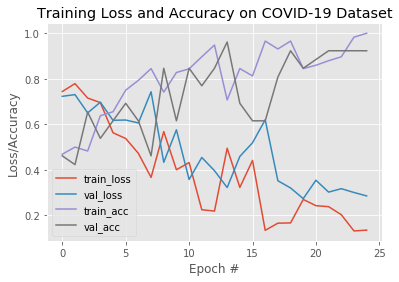

In [18]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")


In [29]:
model.predict(testX)

array([[0.31367815, 0.70720917],
       [0.02846724, 0.95367014],
       [0.08331624, 0.85110676],
       [0.894609  , 0.18942028],
       [0.7565845 , 0.28614253],
       [0.52800083, 0.5774329 ],
       [0.15760744, 0.8045157 ],
       [0.9391061 , 0.14107677],
       [0.5360592 , 0.60325   ],
       [0.15698439, 0.8237709 ],
       [0.6257249 , 0.45040292],
       [0.1637165 , 0.813241  ],
       [0.07553486, 0.9129726 ]], dtype=float32)

In [37]:
y_pred_test = model.predict(testX)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)

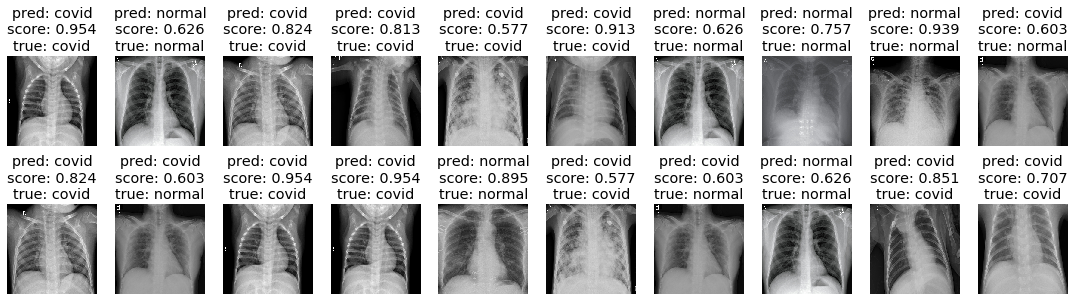

In [68]:
corona = ['normal','covid']
cols = 10
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(testY))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(testX[random_index, :])
        pred_label =  corona[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = corona[int(testY[random_index, 1])]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()

In [60]:
testY

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [61]:
model.predict(testX)

array([[0.31367815, 0.70720917],
       [0.02846724, 0.95367014],
       [0.08331624, 0.85110676],
       [0.894609  , 0.18942028],
       [0.7565845 , 0.28614253],
       [0.52800083, 0.5774329 ],
       [0.15760744, 0.8045157 ],
       [0.9391061 , 0.14107677],
       [0.5360592 , 0.60325   ],
       [0.15698439, 0.8237709 ],
       [0.6257249 , 0.45040292],
       [0.1637165 , 0.813241  ],
       [0.07553486, 0.9129726 ]], dtype=float32)

In [62]:
np.argmax(y_pred_test, axis=1)

array([1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1], dtype=int64)

In [66]:
np.max(y_pred_test, axis=1)

array([0.70720917, 0.95367014, 0.85110676, 0.894609  , 0.7565845 ,
       0.5774329 , 0.8045157 , 0.9391061 , 0.60325   , 0.8237709 ,
       0.6257249 , 0.813241  , 0.9129726 ], dtype=float32)